In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import utils
from sklearn.model_selection import train_test_split

CPU times: user 2.07 s, sys: 772 ms, total: 2.84 s
Wall time: 6.18 s


In [2]:
%load_ext tensorboard

In [3]:
# Change directory to src to import functions from load.py
%cd "../src"
from models import u_dense_net
from generators import DataGen
from losses import soft_dice_loss
from load import get_values_sql, compressed2img, object2numeric_array

/home/rajk/DIT/ADLR/tum-adlr-ss21-11/src


# Local functions

In [4]:
def load_world_data(db_path, n_voxels, n_dim):
    worlds = get_values_sql(file=db_path, table="worlds")
    obstacle_images = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    return obstacle_images

def load_data(db_path, path_indexes, n_voxels, n_dim):    
    paths = get_values_sql(file=db_path, table='paths', rows=path_indexes)
    path_images = compressed2img(img_cmp=paths.path_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    start_images = compressed2img(img_cmp=paths.start_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    end_images = compressed2img(img_cmp=paths.end_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    
    q_paths = object2numeric_array(paths.q_path.values)
    q_paths = q_paths.reshape(-1, n_waypoints, n_dim)
    return start_images, end_images, path_images

def image2image_callback(batch_indexes, data_dict):
    path_indexes = data_dict["path_rows"][batch_indexes]
    obst_indexes = path_indexes//n_paths_per_world
    obst_batch_data = data_dict["obst_imgs"][obst_indexes]
    goal_batch_data = data_dict["goal_imgs"][batch_indexes]
    path_batch_data = data_dict["path_imgs"][batch_indexes]
    input_batch_data = [np.concatenate([obst_batch_data, goal_batch_data], axis=-1)]
    output_batch_data = [path_batch_data]
    return input_batch_data, output_batch_data

# Init global variables

In [5]:
db_path = r"../SingleSphere02.db"   # Path of the data in your local machine

n_voxels = 64
voxel_size = 10 / 64     # in m
extent = [0, 10, 0, 10]  # in m
n_waypoints = 22         # start + 20 inner points + end
n_dim = 2
n_paths_per_world = 1000
n_worlds = 50000
path_rows = np.arange(0, n_worlds, step=10)

batch_size = 32
validation_ratio = 0.1
input_shape = (n_voxels, n_voxels, 2)

# Load training and validation data

In [6]:
%%time
obst_imgs = load_world_data(db_path, n_voxels, n_dim)

start_imgs, end_imgs, path_imgs = load_data(db_path, path_rows, n_voxels, n_dim)
goal_imgs = start_imgs + end_imgs            # Add start and end images together
# Expand dimension of images to create the channel layer
obst_imgs, goal_imgs, path_imgs = (
    np.expand_dims(data, axis=-1) 
    for data in (obst_imgs, goal_imgs, path_imgs)
)
del start_imgs, end_imgs

/home/rajk/DIT/ADLR/tum-adlr-ss21-11/src/load.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array([np.frombuffer(v, dtype=int) for v in value])


CPU times: user 513 ms, sys: 113 ms, total: 626 ms
Wall time: 2.29 s


In [7]:
# TODO: Use better uniform data split technique 
train_goal_imgs, validation_goal_imgs, train_path_imgs, validation_path_imgs = train_test_split(goal_imgs, path_imgs.astype("float32"), test_size=validation_ratio)
train_data_dict = {
    "path_rows": path_rows,
    "obst_imgs": obst_imgs,
    "goal_imgs": train_goal_imgs,
    "path_imgs": train_path_imgs
}

validation_data_dict = {
    "path_rows": path_rows,
    "obst_imgs": obst_imgs,
    "goal_imgs": validation_goal_imgs,
    "path_imgs": validation_path_imgs
}

In [8]:
train_data_gen = DataGen(train_data_dict, callback=image2image_callback, batch_size=batch_size)
validation_data_gen = DataGen(validation_data_dict, callback=image2image_callback, batch_size=batch_size)

# Visualize Graph

In [16]:
%tensorboard --logdir "temp"

# Load U-DenseNet model

/home/rajk/DIT/ADLR/tum-adlr-ss21-11/notebook
Model: "DenseNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 64, 64, 2)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   1632        image_input[0][0]                
__________________________________________________________________________________________________
dense_block (DenseBlock)        (None, 64, 64, 128)  56160       conv2d[0][0]                     
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 64, 64, 160)  0           conv2d[0][0]                     
                                             

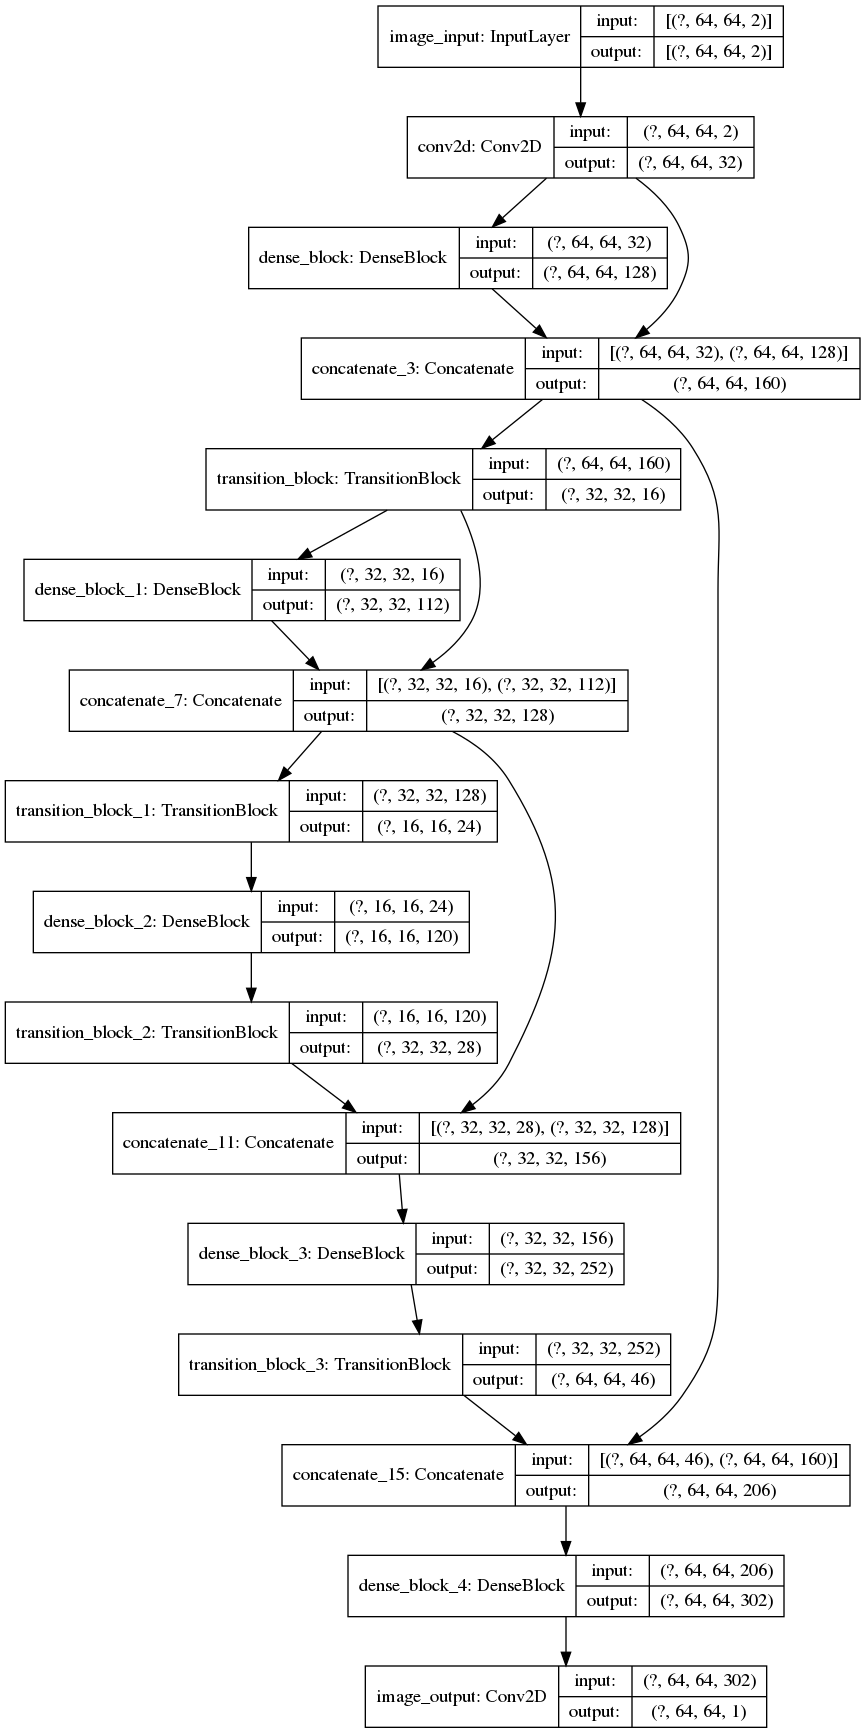

In [10]:
%cd "../notebook"
!rm -rf "temp"
tf.keras.backend.clear_session()
denseNet = u_dense_net(input_shape, num_db=5, num_channels=32, growth_rate=32, convs_per_db=3)
optimizer = tf.keras.optimizers.Adam(lr=3e-4)
denseNet.compile(optimizer=optimizer, loss=soft_dice_loss)
denseNet.summary()
utils.plot_model(denseNet, show_shapes=True)    # Saves model graph as model.png

In [11]:
%%time
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="temp"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)
]
history = denseNet.fit(train_data_gen, validation_data=validation_data_gen, epochs=100, callbacks=callbacks)

Epoch 1/100
141/141 [==============================] - 60s 423ms/step - loss: 0.5334 - val_loss: 0.9998
Epoch 2/100
141/141 [==============================] - 30s 215ms/step - loss: 0.4286 - val_loss: 1.0000
Epoch 3/100
141/141 [==============================] - 30s 215ms/step - loss: 0.3618 - val_loss: 0.9359
Epoch 4/100
141/141 [==============================] - 30s 216ms/step - loss: 0.3320 - val_loss: 0.6236
Epoch 5/100
141/141 [==============================] - 30s 215ms/step - loss: 0.3168 - val_loss: 0.5046
Epoch 6/100
141/141 [==============================] - 30s 216ms/step - loss: 0.3057 - val_loss: 0.3118
Epoch 7/100
141/141 [==============================] - 30s 216ms/step - loss: 0.2977 - val_loss: 0.3120
Epoch 8/100
141/141 [==============================] - 31s 216ms/step - loss: 0.2910 - val_loss: 0.3062
Epoch 9/100
141/141 [==============================] - 31s 217ms/step - loss: 0.2871 - val_loss: 0.4040
Epoch 10/100
141/141 [==============================] - 31s 216m

In [12]:
test_path_rows = np.arange(n_worlds, n_worlds+5000, step=10)
test_start_imgs, test_end_imgs, test_path_imgs = load_data(db_path, test_path_rows, n_voxels, n_dim)
test_goal_imgs = test_start_imgs + test_end_imgs
test_goal_imgs, test_path_imgs = (
    np.expand_dims(data, axis=-1) 
    for data in (test_goal_imgs, test_path_imgs)
)
del test_start_imgs, test_end_imgs

In [13]:
world_indexes = test_path_rows//n_paths_per_world
test_data = np.concatenate([obst_imgs[world_indexes], test_goal_imgs], axis=-1)
out_data = denseNet.predict(test_data)

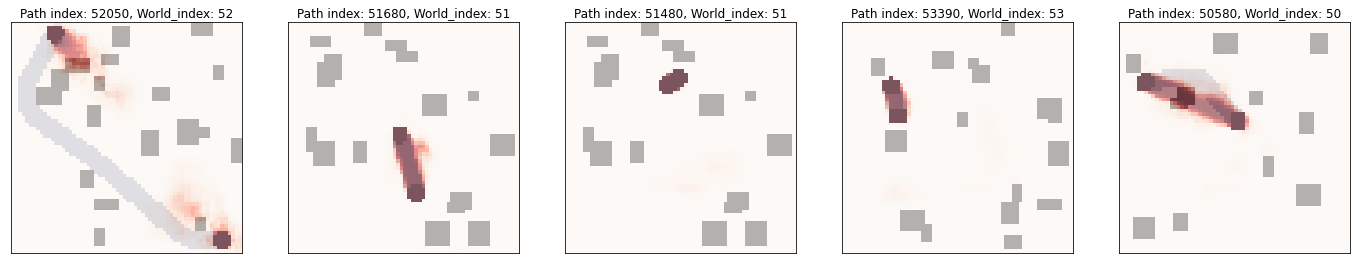

In [15]:
N = 5
path_indexes = np.random.choice(test_path_rows, size=N)
_, axs = plt.subplots(nrows=1, ncols=N, figsize=((1+N)*4, 10))
for path_i, ax in zip(path_indexes, axs):
    i = np.where(test_path_rows==path_i)[0].item()
    obst_img = obst_imgs[path_i//n_paths_per_world]
    test_goal_img = test_goal_imgs[i]
    test_path_img = test_path_imgs[i]

    ax.imshow(obst_img[:, :, 0], origin='lower', extent=extent, cmap='binary')
    ax.imshow(test_goal_img[:, :, 0], origin='lower', extent=extent, cmap='Greens', alpha=0.25)
    ax.imshow(test_path_img[:, :, 0], origin='lower', extent=extent, cmap='Blues', alpha=0.25)
    ax.imshow(out_data[i, :, :, 0], origin='lower', extent=extent, cmap='Reds', alpha=0.5)
    ax.set_title(f"Path index: {path_i}, World_index: {path_i//n_paths_per_world}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()